# Semana 3
# Laboratorio Guiado Modelos No Supervisados
# Clustering y Reducción de Dimensionalidad
# Deber Grupal

In [ ]:


# Parte 1: Preparación del entorno

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


             Total_Sales  Avg_Sales  Total_Profit  Avg_Profit  Total_Quantity  \
Customer_Id                                                                     
10000              293.0      146.5         167.1       83.55             2.0   
10002              149.0      149.0          66.0       66.00             2.0   
10004               85.0       85.0           1.6        1.60             4.0   
10006              440.0      220.0         269.0      134.50             3.0   
10013              159.0      159.0          74.2       74.20             1.0   

             Avg_Discount  Avg_Shipping  Purchase_Frequency  Avg_Aging  
Customer_Id                                                             
10000                0.30          8.35                   2        3.5  
10002                0.10          6.60                   1       10.0  
10004                0.50          0.20                   1        7.0  
10006                0.15         13.45                   2        

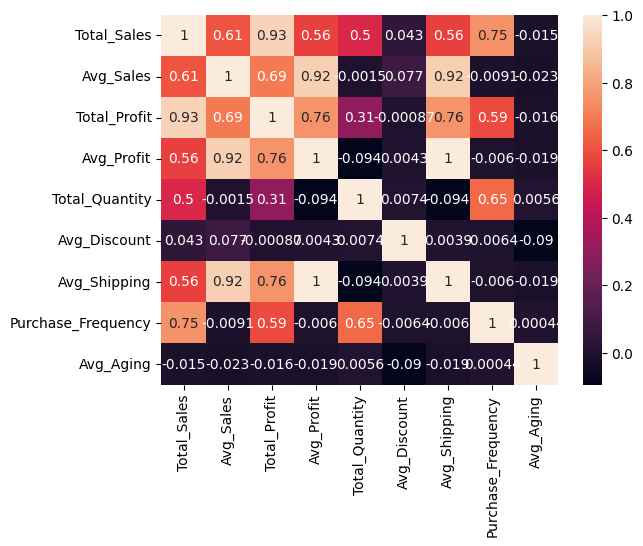

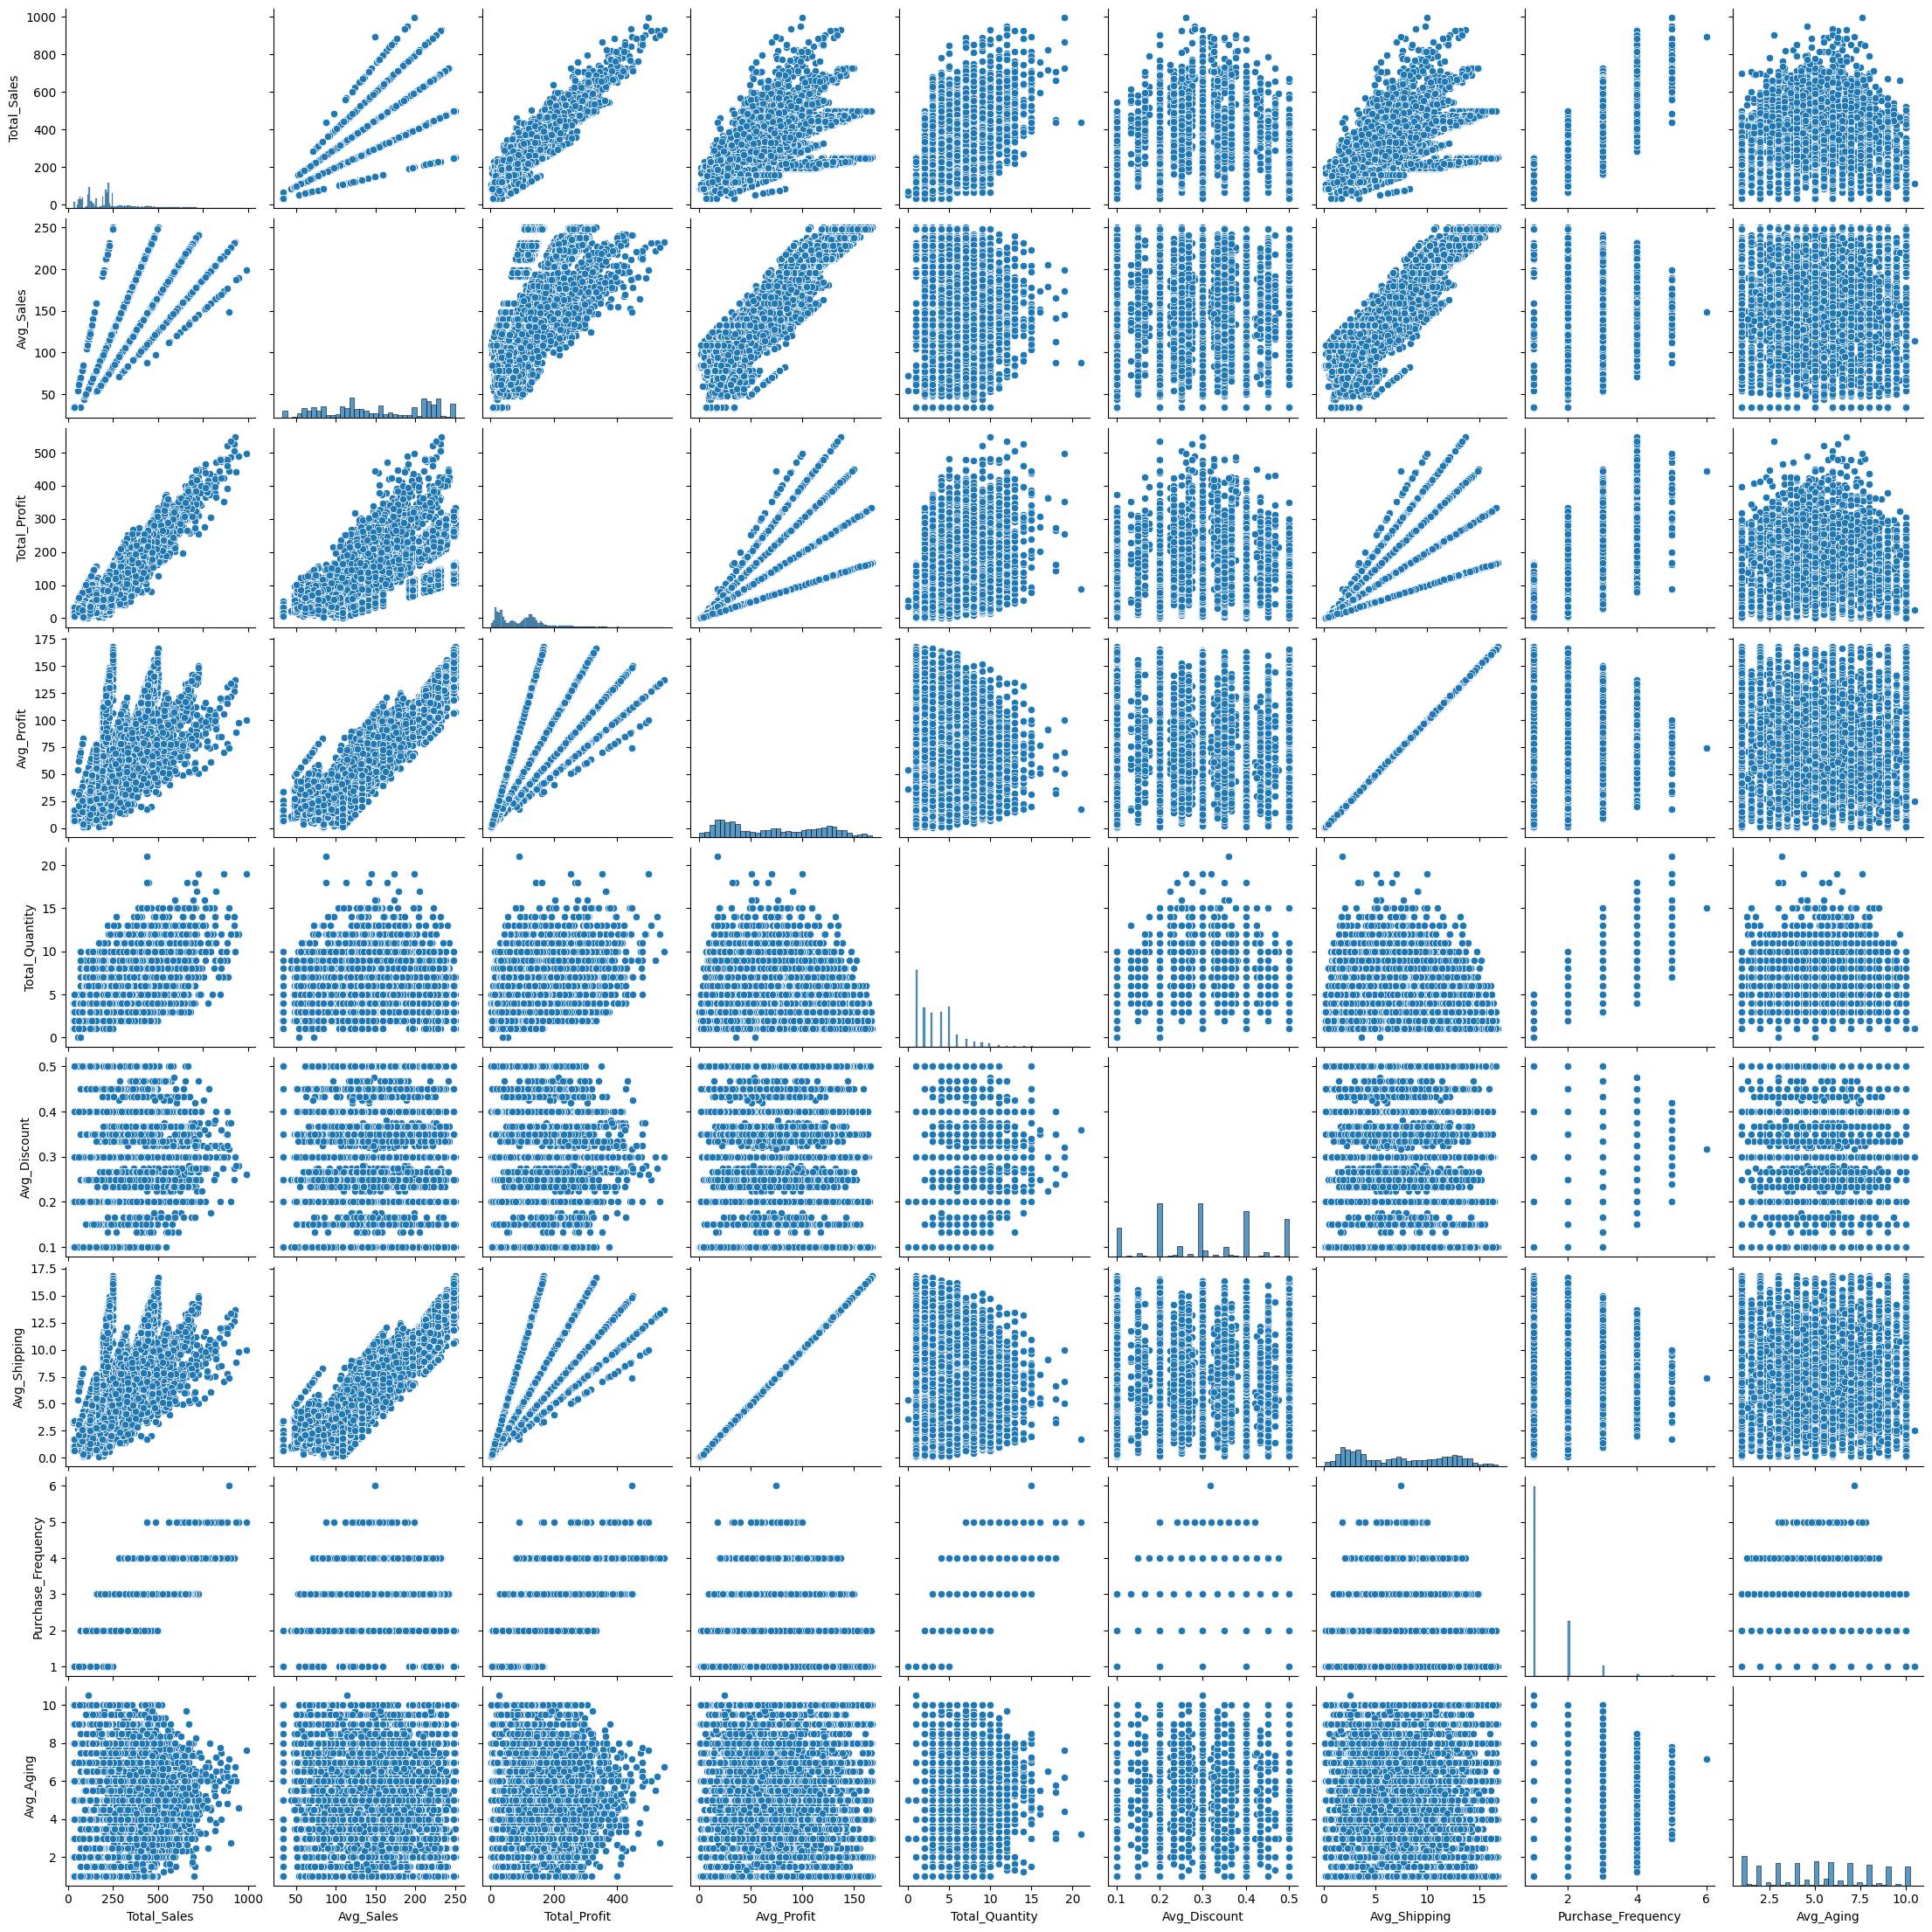

In [ ]:
# Parte 2: Carga y análisis exploratorio de los datos
df = pd.read_csv('E-commerce Dataset.csv')


# Considerando que las columnas originales representan valores categoricos y no continuos, se procede a realizar
# un tratamiento del dataset para enfocarnos en datos que describan a los clientes



# Parte 2.1: Revision detallada de columnas



# Conertir Fechas
df['Order_Date'] = pd.to_datetime(df['Order_Date'])


# Crear variables de comportamiento por cliente
customer_df = df.groupby('Customer_Id').agg({

    # Valor monetario
    'Sales': ['sum', 'mean'],
    'Profit': ['sum', 'mean'],

    # Volumen
    'Quantity': 'sum',

    # Sensibilidad a descuentos
    'Discount': 'mean',

    # Costos
    'Shipping_Cost': 'mean',

    # Frecuencia
    'Order_Date': 'count',

    # Tiempo promedio de entrega
    'Aging': 'mean'

})

# Renombrar Columnas
customer_df.columns = [
    'Total_Sales',
    'Avg_Sales',
    'Total_Profit',
    'Avg_Profit',
    'Total_Quantity',
    'Avg_Discount',
    'Avg_Shipping',
    'Purchase_Frequency',
    'Avg_Aging'
]


#Eliminar clientes con datos faltantes
customer_df = customer_df.dropna()


# Análisis Exploratorio (EDA)
print(customer_df.head())
print(customer_df.info())
print(customer_df.describe())


# Visualización de la correlacion
sns.heatmap(customer_df.corr(), annot=True)



# Visualización de la distribución
sns.pairplot(customer_df[[ 'Total_Sales','Avg_Sales','Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount', 'Avg_Shipping', 'Purchase_Frequency', 'Avg_Aging' ]])
plt.show()


**Escalamiento de variables continuas**
        
App Usage Time (min/day)      
Screen On Time (hours/day)  
Battery Drain (mAh/day)       
Number of Apps Installed      
Data Usage (MB/day)           


In [ ]:
# Parte 3: Preprocesamiento

# Escalado

X = customer_df[['Total_Sales','Avg_Sales','Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount', 'Avg_Shipping', 'Purchase_Frequency', 'Avg_Aging' ]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(customer_df)



**Aplicacion de K-Means Clustering**

Se aplica analisis de metodo de codo para identificar el numero de cluster recomendados; sin embargo por las imagenes de correlacion de las variables; se puede anticipar que hay 5 grupos bien definidos

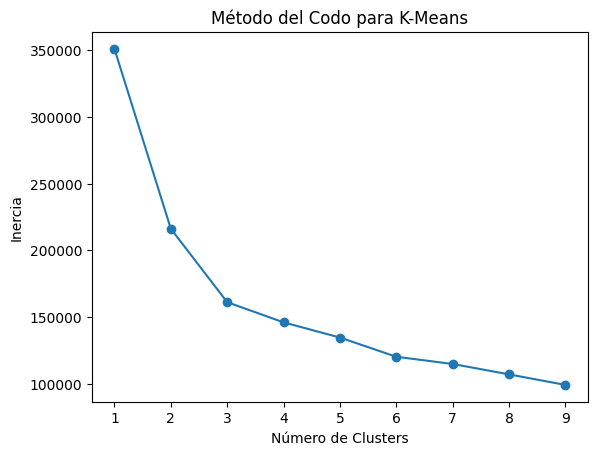

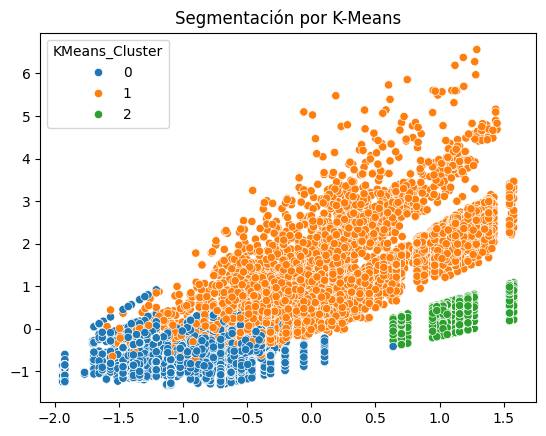

In [ ]:


# Parte 4.1: Clustering con K-Means
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Método del Codo
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de Clusters') # Numero de grupos
plt.ylabel('Inercia') # la suma de las distancias cuadradas de cada punto a su centroide (cuánto error hay dentro de cada cluster).
plt.title('Método del Codo para K-Means')
plt.show()



# Ajuste del modelo con K óptimo (ej. 3)
kmeans = KMeans(n_clusters=3, random_state=42)
customer_df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=customer_df['KMeans_Cluster'], palette='tab10')
plt.title('Segmentación por K-Means')
plt.show()


In [ ]:
# Parte 4.1.1: Interpretación de Clustering con K-Means


customer_df.groupby('KMeans_Cluster')[['Total_Sales','Avg_Sales','Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount', 'Avg_Shipping', 'Purchase_Frequency', 'Avg_Aging' ]].mean()

# Conclusion
# Se idendtifican 3 grupos bien definidos que pueden interpretarse como Clientes con Promedio de Compra Bajo, Medio y Alto.
# En este analisis se puede identificar que los clientes con proemdio de compra Medio, representan una mejor utilidad o profit.



,Total_Sales,Avg_Sales,Total_Profit,Avg_Profit,Total_Quantity,Avg_Discount,Avg_Shipping,Purchase_Frequency,Avg_Aging
KMeans_Cluster,,,,,,,,,
0,111.130954,98.608976,34.287443,30.474148,2.803057,0.294457,3.050072,1.132731,5.321671
1,381.378926,169.820119,185.706826,83.202780,5.794446,0.305596,8.320089,2.275240,5.222136
2,221.048312,221.048312,121.386120,121.386120,2.489024,0.317523,12.138052,1.000000,5.176253


Analisis DBSCAN

* Encuentra agrupaciones densas de puntos sin necesidad de saber cuántos clusters hay.

* Identifica automáticamente "ruido" o "outliers", etiquetándolos como -1.

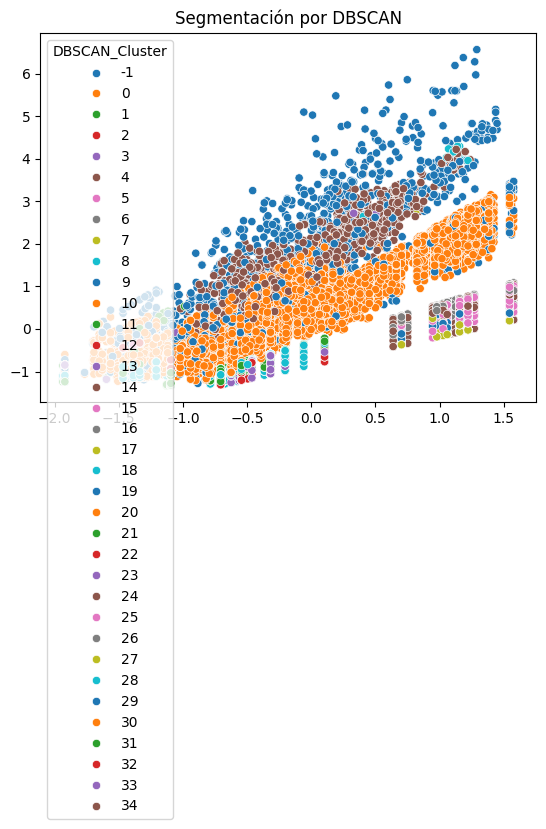

In [ ]:
# Parte 4.2: Clustering con DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=5) # eps = radio máximo para considerar que dos puntos están “cerca”./ min_samples =  número mínimo de puntos vecinos necesarios para formar un cluster.
customer_df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=customer_df['DBSCAN_Cluster'], palette='tab10')
plt.title('Segmentación por DBSCAN')
plt.show()


#Conclusion
#DBScan recomienda segmentar en 30 grupos; y existe un grupo OUTLIER representativo lo cual indica que se encontraron datos de tipo RUIDO.


In [ ]:
# Parte 4.2.1: Interpretando los Clustering con DBSCAN

customer_df['DBSCAN_Cluster'].value_counts()
customer_df.groupby('DBSCAN_Cluster')[['Total_Sales','Avg_Sales','Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount', 'Avg_Shipping', 'Purchase_Frequency', 'Avg_Aging' ]].mean()


,Total_Sales,Avg_Sales,Total_Profit,Avg_Profit,Total_Quantity,Avg_Discount,Avg_Shipping,Purchase_Frequency,Avg_Aging
DBSCAN_Cluster,,,,,,,,,
-1,430.311147,146.035418,200.784924,68.424746,7.590217,0.311165,6.844028,2.927025,5.324472
0,303.963433,151.981717,140.226791,70.113395,4.995979,0.301659,7.011975,2.000000,5.245413
1,104.103586,104.103586,31.850996,31.850996,2.377158,0.100000,3.189243,1.000000,5.469677
2,106.613189,106.613189,27.734419,27.734419,2.488540,0.500000,2.778046,1.000000,4.722557
3,99.252035,99.252035,27.136440,27.136440,2.660541,0.300000,2.712497,1.000000,5.549882
4,221.861832,221.861832,126.468435,126.468435,2.445420,0.200000,12.646985,1.000000,5.432061
5,222.027174,222.027174,119.069275,119.069275,2.576449,0.300000,11.906087,1.000000,5.557609
6,222.548698,222.548698,133.732050,133.732050,2.398075,0.100000,13.379105,1.000000,5.417327
7,220.780998,220.780998,115.953265,115.953265,2.520543,0.500000,11.593874,1.000000,4.677916


In [ ]:
# Parte 4.2.1: Interpretando los Clustering con DBSCAN sin atípicos

df_no_noise = customer_df[customer_df['DBSCAN_Cluster'] != -1]
df_no_noise.groupby('DBSCAN_Cluster')[['Total_Sales','Avg_Sales','Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount', 'Avg_Shipping', 'Purchase_Frequency', 'Avg_Aging']].mean()

,Total_Sales,Avg_Sales,Total_Profit,Avg_Profit,Total_Quantity,Avg_Discount,Avg_Shipping,Purchase_Frequency,Avg_Aging
DBSCAN_Cluster,,,,,,,,,
0,303.963433,151.981717,140.226791,70.113395,4.995979,0.301659,7.011975,2.0,5.245413
1,104.103586,104.103586,31.850996,31.850996,2.377158,0.100000,3.189243,1.0,5.469677
2,106.613189,106.613189,27.734419,27.734419,2.488540,0.500000,2.778046,1.0,4.722557
3,99.252035,99.252035,27.136440,27.136440,2.660541,0.300000,2.712497,1.0,5.549882
4,221.861832,221.861832,126.468435,126.468435,2.445420,0.200000,12.646985,1.0,5.432061
5,222.027174,222.027174,119.069275,119.069275,2.576449,0.300000,11.906087,1.0,5.557609
6,222.548698,222.548698,133.732050,133.732050,2.398075,0.100000,13.379105,1.0,5.417327
7,220.780998,220.780998,115.953265,115.953265,2.520543,0.500000,11.593874,1.0,4.677916
8,99.119017,99.119017,29.416688,29.416688,2.589651,0.200000,2.947400,1.0,5.506598


**PCA (Principal Component Analysis)**

* Reduce el número de variables (dimensiones) de un dataset.
* Conserva la mayor parte de la variabilidad (información) de los datos originales.
* Transforma los datos a componentes principales que son combinaciones lineales de las variables originales.

Cinco variables originales

'Total_Sales','Avg_Sales','Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount', 'Avg_Shipping', 'Purchase_Frequency', 'Avg_Aging'

a:

Dos nuevas variables artificiales, llamadas Componentes principales: PC1 y PC2.



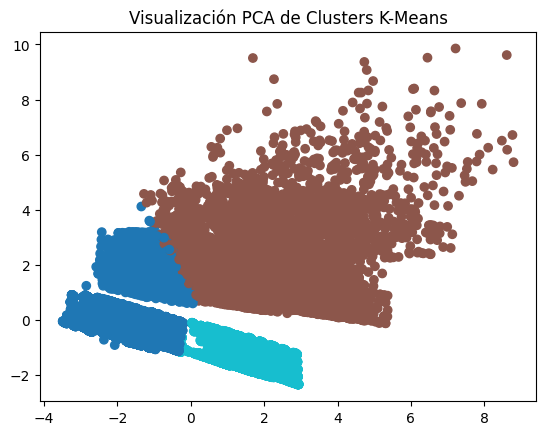

In [ ]:
# Parte 5.1: Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización PCA de Clusters K-Means')
plt.show()


In [ ]:
# Parte 5.1.1: Interpretación de Reducción de dimensionalidad con PCA
customer_df.groupby('KMeans_Cluster')[['Total_Sales','Avg_Sales','Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount', 'Avg_Shipping', 'Purchase_Frequency', 'Avg_Aging']].mean()


,Total_Sales,Avg_Sales,Total_Profit,Avg_Profit,Total_Quantity,Avg_Discount,Avg_Shipping,Purchase_Frequency,Avg_Aging
KMeans_Cluster,,,,,,,,,
0,111.130954,98.608976,34.287443,30.474148,2.803057,0.294457,3.050072,1.132731,5.321671
1,381.378926,169.820119,185.706826,83.202780,5.794446,0.305596,8.320089,2.275240,5.222136
2,221.048312,221.048312,121.386120,121.386120,2.489024,0.317523,12.138052,1.000000,5.176253


In [ ]:
# Parte 5.1.2: Interpretación detallada de Reducción de dimensionalidad con PCA
# Mostrar algunos clientes por cluster
for i in range(3):
    print(f"\nCluster {i}")
    display(customer_df[customer_df['KMeans_Cluster'] == i][['Total_Sales','Avg_Sales','Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount', 'Avg_Shipping', 'Purchase_Frequency', 'Avg_Aging']].head())



Cluster 0


,Total_Sales,Avg_Sales,Total_Profit,Avg_Profit,Total_Quantity,Avg_Discount,Avg_Shipping,Purchase_Frequency,Avg_Aging
Customer_Id,,,,,,,,,
10002,149.0,149.0,66.0,66.0,2.0,0.1,6.6,1,10.0
10004,85.0,85.0,1.6,1.6,4.0,0.5,0.2,1,7.0
10013,159.0,159.0,74.2,74.2,1.0,0.3,7.4,1,8.0
10019,114.0,114.0,30.6,30.6,1.0,0.1,3.1,1,7.0
10026,85.0,85.0,42.5,42.5,2.0,0.5,4.3,1,8.0



Cluster 1


,Total_Sales,Avg_Sales,Total_Profit,Avg_Profit,Total_Quantity,Avg_Discount,Avg_Shipping,Purchase_Frequency,Avg_Aging
Customer_Id,,,,,,,,,
10000,293.0,146.5,167.1,83.55,2.0,0.30,8.35,2,3.5
10006,440.0,220.0,269.0,134.50,3.0,0.15,13.45,2,6.0
10045,340.0,170.0,143.0,71.50,6.0,0.40,7.15,2,7.0
10059,466.0,233.0,253.2,126.60,6.0,0.45,12.65,2,3.0
10063,340.0,170.0,147.2,73.60,3.0,0.40,7.35,2,4.0



Cluster 2


,Total_Sales,Avg_Sales,Total_Profit,Avg_Profit,Total_Quantity,Avg_Discount,Avg_Shipping,Purchase_Frequency,Avg_Aging
Customer_Id,,,,,,,,,
10015,224.0,224.0,130.6,130.6,1.0,0.2,13.1,1,6.0
10023,231.0,231.0,146.4,146.4,1.0,0.2,14.6,1,8.0
10024,250.0,250.0,107.5,107.5,5.0,0.3,10.8,1,7.0
10027,211.0,211.0,126.8,126.8,1.0,0.1,12.7,1,2.0
10038,231.0,231.0,116.4,116.4,5.0,0.3,11.6,1,4.0


**Aplicacion de Tecnica t-SNE?**

t-SNE es una técnica de reducción de dimensionalidad no lineal diseñada específicamente para visualización de datos complejos en 2D o 3D.


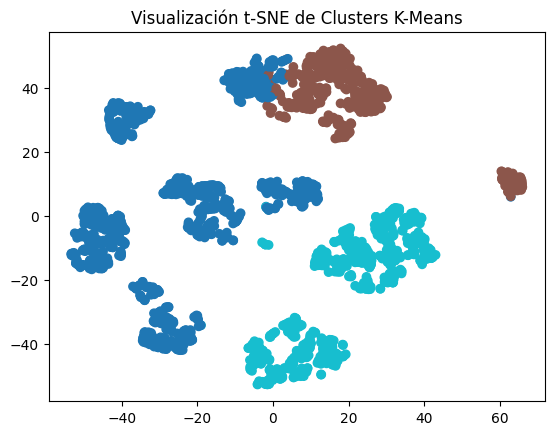

In [ ]:

customer_df.shape


# Parte 5.2: Reducción de dimensionalidad con t-SNE

sample_df = customer_df.sample(2000, random_state=42)
X_sample = scaler.fit_transform(sample_df.drop(columns=['KMeans_Cluster']))

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42) # cuántos vecinos cercanos considera t-SNE / cuánto se mueven los puntos
# X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sample_df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización t-SNE de Clusters K-Means')
plt.show()


In [ ]:
# Parte 5.2.1: Interpretación de Reducción de dimensionalidad con t-SNE
customer_df.groupby('KMeans_Cluster')[['Total_Sales','Avg_Sales','Total_Profit', 'Avg_Profit', 'Total_Quantity', 'Avg_Discount', 'Avg_Shipping', 'Purchase_Frequency', 'Avg_Aging']].mean()


,Total_Sales,Avg_Sales,Total_Profit,Avg_Profit,Total_Quantity,Avg_Discount,Avg_Shipping,Purchase_Frequency,Avg_Aging
KMeans_Cluster,,,,,,,,,
0,111.130954,98.608976,34.287443,30.474148,2.803057,0.294457,3.050072,1.132731,5.321671
1,381.378926,169.820119,185.706826,83.202780,5.794446,0.305596,8.320089,2.275240,5.222136
2,221.048312,221.048312,121.386120,121.386120,2.489024,0.317523,12.138052,1.000000,5.176253


In [ ]:
# Parte 6: Análisis
print("Clusters únicos KMeans:", customer_df['KMeans_Cluster'].unique())
print("Clusters únicos DBSCAN:", customer_df['DBSCAN_Cluster'].unique())

# Conclusión
# El modelo K-Means segmenta a los clientes en tres grupos claramente diferenciados por total de compras y su promedio,
# que pueden interpretarse como bajo,, medio y alto.
# Sin embargo el modelo DBScan sugiere 30 agrupaciones; lo cual no puede ser interpretado como una clusterizacion coherente.


Clusters únicos KMeans: [1 0 2]
Clusters únicos DBSCAN: [ 0  1  2  3  4  5  6  7  8  9 10 11 14 12 13 -1 15 16 17 18 32 29 19 21
 34 20 24 27 26 30 33 28 22 23 25 31]



**Análisis y conclusiones**


🔹 ¿Cuántos clusters parecen ser óptimos según K-means?

Según el análisis del método del codo (Elbow Method) y la coherencia de los grupos obtenidos, tres clusters (k = 3) resultan ser una elección adecuada.
Este valor permite capturar distintos perfiles de clientes segun su promedio de compra

🔹 ¿Cómo se comparan los resultados entre K-means y DBSCAN?

K-means logra una segmentación consistente de los usuarios en función del promedio de compra, generando grupos bien definidos y balanceados.
Por su parte, DBSCAN muestra limitaciones en este dataset, ya que tiende a identificar 30 grupos dispersos

En este contexto, K-means resulta más adecuado que DBSCAN para identificar patrones globales de comportamiento.

🔹 ¿Qué aporta PCA / t-SNE a la interpretación de los clusters?

PCA y t-SNE permiten reducir la dimensionalidad de los datos y visualizar los clusters en dos dimensiones, facilitando su interpretación.

Estas técnicas muestran que la separación entre grupos sigue principalmente un eje de variación asociado al promedio de compra, confirmando que los clusters identificados por K-means reflejan una segmentacion coherente

🔹 ¿Qué tipo de perfiles de clientes has detectado?

El análisis revela cinco perfiles de usuarios diferenciados principalmente por el nivel de uso del dispositivo:

* Clientes de nivel bajo de compra
* Clientes de nivel medio de compra; con margen alto y mayor frecuencia
* Clientes de nivel alto de compra

